https://www.youtube.com/watch?v=lIhGv1oYS8U&list=PLlIJjE1EmA8Y6egvj9yRgJbbxf_iEmPYv&index=19
https://people.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
from scipy.optimize import minimize

tickers = ['JPM', 'TSLA', 'AMZN', 'MRK','XOM']

# Fetch historical price data
data = yf.download(tickers, period='2y', auto_adjust=True)['Close']

returns = np.log(data / data.shift(1)).dropna()
# Download market capitalization data
market_cap = []
for ticker in tickers:
    market_cap.append(yf.Ticker(ticker).info['marketCap'])
    
# Calculate market weight
market_cap_w = [x/sum(market_cap) for x in market_cap]

[*********************100%***********************]  5 of 5 completed


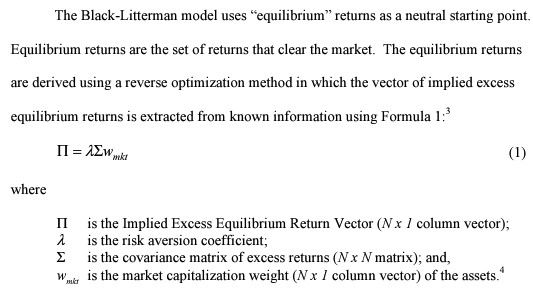

In [25]:
# Calculate covariance matrix
Sigma = returns.cov().values

#Risk Aversion Coefficient = excess return/ Variance (from CAPM)
risk_aversion = 3

# Market's implied excess returns
mu = risk_aversion * Sigma @ market_cap_w

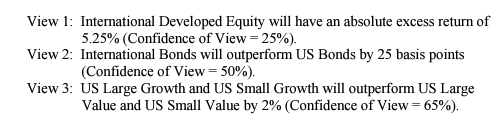

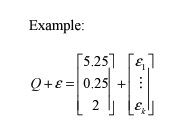
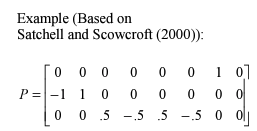
or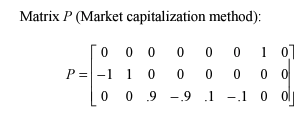

In [26]:
#View1: MRK outperform JPM by 1%
#View2: TSLA, AMZN outperform JPM,MRK by 1%
P = np.array([[-1, 0, 0,1,0],
              [-0.6, 0.6, 0.4,-0.4,0]]) # Investor's views matrix

q = np.array([0.01, 0.01])  # Investor's views on expected excess return

#black literman recommend Omega = P @ Sigma @ P.T 
Omega = P @ Sigma @ P.T   # Uncertainty matrix

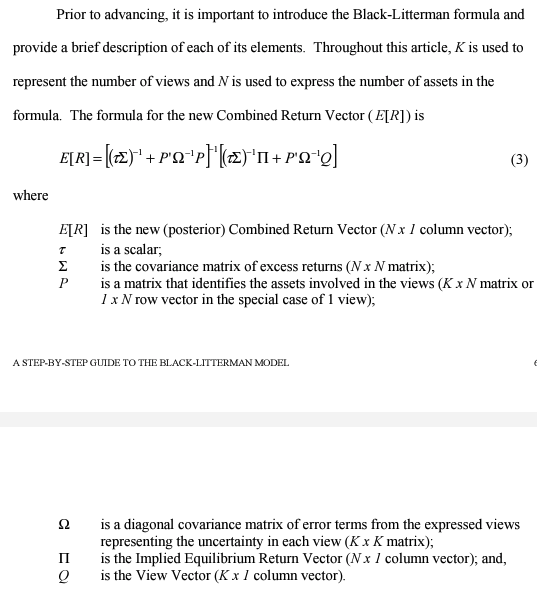

In [27]:
# Calculate the expected returns using the Black-Litterman formula
# Market's implied excess returns -> BL -> expected return
scalar = 0.05
Sigma_inv = np.linalg.inv(scalar * Sigma)
Omega_inv = np.linalg.inv(Omega)

first_term = np.linalg.inv(Sigma_inv + P.T @ Omega_inv @ P)
second_term = Sigma_inv @ mu + P.T @ Omega_inv @ q

mu_expected = first_term @ second_term

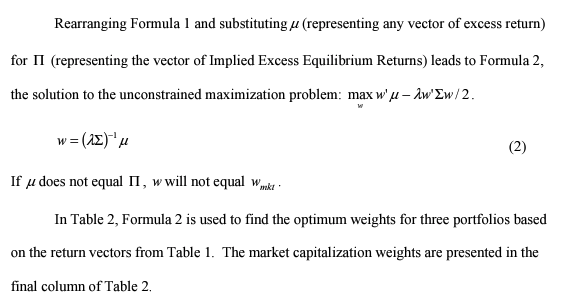

In [33]:
# mean variance
def calculate_portfolio_var(w, V):
    # Function that calculates portfolio risk
    w = np.array(w)
    return np.dot(np.dot(w, V), w.T)

def calculate_portfolio_return(w, R):
    # Function that calculates portfolio return
    w = np.array(w)
    return np.dot(w, R)

def risk_budget_objective(x, *pars):
    # Calculate portfolio risk
    V = pars[0]  # Covariance matrix
    R = pars[1]  # Expected returns
    risk_aversion = pars[2]  # Risk aversion parameter

    # Mean-variance objective
    portfolio_return = calculate_portfolio_return(x, R)
    portfolio_var = calculate_portfolio_var(x, V)

    utility = portfolio_return - 0.5 * risk_aversion * portfolio_var

    return - utility

def total_weight_constraint(x):
    return np.sum(x) - 1.0

def long_only_constraint(x):
    return x

# Input data
w0 = [0.3, 0.1, 0.2, 0.3,0.1]  # Initial weights

# Define constraints
cons = ({'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint})

# Solve the optimization problem
res = minimize(risk_budget_objective, w0, args=(Sigma, mu_expected, risk_aversion),
               method='SLSQP', constraints=cons, options={'disp': True})

# Retrieve the optimized weights
w_rb_mv = np.asmatrix(res.x)
w_rb_mv

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00019649224947193133
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6


matrix([[0.024438  , 0.25569167, 0.44884819, 0.00286148, 0.26816066]])